In [ ]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
#import warnings
import ipywidgets
from IPython.display import clear_output
from keras.callbacks import Callback
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.activations import hard_sigmoid
from scipy import stats
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(14,7))
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot_losses = PlotLearning()

In [206]:
df = pd.read_csv('Data_Cortex_Nuclear.csv')  

In [ ]:
df.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,...,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,0.687906,0.306382,0.402698,0.296927,1.022060,0.605673,1.877684,2.308745,0.441599,0.859366,0.416289,0.369608,0.178944,1.866358,3.685247,1.537227,0.264526,0.319677,0.813866,0.165846,0.453910,3.037621,0.369510,0.458539,0.335336,0.825192,0.576916,0.448099,0.586271,...,0.482864,0.294170,0.182150,0.842725,0.192608,1.443091,0.294700,0.354605,1.339070,0.170119,0.159102,0.188852,0.106305,0.144989,0.176668,0.125190,0.115291,0.228043,0.142756,0.430957,0.247538,1.603310,2.014875,0.108234,1.044979,0.831557,0.188852,0.122652,NaN,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,0.695006,0.299051,0.385987,0.281319,0.956676,0.587559,1.725774,2.043037,0.445222,0.834659,0.400364,0.356178,0.173680,1.761047,3.485287,1.509249,0.255727,0.304419,0.780504,0.157194,0.430940,2.921882,0.342279,0.423560,0.324835,0.761718,0.545097,0.420876,0.545097,...,0.454519,0.276431,0.182086,0.847615,0.194815,1.439460,0.294060,0.354548,1.306323,0.171427,0.158129,0.184570,0.106592,0.150471,0.178309,0.134275,0.118235,0.238073,0.142037,0.457156,0.257632,1.671738,2.004605,0.109749,1.009883,0.849270,0.200404,0.116682,NaN,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,0.677348,0.291276,0.381002,0.281710,1.003635,0.602449,1.731873,2.017984,0.467668,0.814329,0.399847,0.368089,0.173905,1.765544,3.571456,1.501244,0.259614,0.311747,0.785154,0.160895,0.423187,2.944136,0.343696,0.425005,0.324852,0.757031,0.543620,0.404630,0.552994,...,0.447197,0.256648,0.184388,0.856166,0.200737,1.524364,0.301881,0.386087,1.279600,0.185456,0.148696,0.190532,0.108303,0.145330,0.176213,0.132560,0.117760,0.244817,0.142445,0.510472,0.255343,1.663550,2.016831,0.108196,0.996848,0.846709,0.193685,0.118508,NaN,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,0.583277,0.296729,0.377087,0.313832,0.875390,0.520293,1.566852,2.132754,0.477671,0.727705,0.385639,0.362970,0.179449,1.286277,2.970137,1.419710,0.259536,0.279218,0.734492,0.162210,0.410615,2.500204,0.344509,0.429211,0.330121,0.746980,0.546763,0.386860,0.547849,...,0.442650,0.398534,0.161768,0.760234,0.184169,1.612382,0.296382,0.290680,1.198765,0.159799,0.166112,0.185323,0.103184,0.140656,0.163804,0.123210,0.117439,0.234947,0.145068,0.430996,0.251103,1.484624,1.957233,0.119883,0.990225,0.833277,0.192112,0.132781,NaN,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,0.550960,0.286961,0.363502,0.277964,0.864912,0.507990,1.480059,2.013697,0.483416,0.687794,0.367531,0.355311,0.174836,1.324695,2.896334,1.359876,0.250705,0.273667,0.702699,0.154827,0.398550,2.456560,0.329126,0.408755,0.313415,0.691956,0.536860,0.360816,0.512824,...,0.419095,0.393447,0.160200,0.768113,0.185718,1.645807,0.296829,0.309345,1.206995,0.164650,0.160687,0.188221,0.104784,0.141983,0.167710,0.136838,0.116048,0.255528,0.140871,0.48

In [207]:
t = pd.Series(df.isna().sum())
t[t>100]

BAD_N        213
BCL2_N       285
H3AcK18_N    180
EGR1_N       210
H3MeK4_N     270
dtype: int64

В нашем датасете есть колонки (признаки), где отонсительно большое число пропусков (больше 180 при том, что всего 1080 строк). Это признаки: 'BAD_N', 'BCL2_N', 'H3AcK18_N', 'EGR1_N', 'H3MeK4_N'. Удалим эти колонки из нашего рассмотрения.

In [208]:
df.drop(columns=['BAD_N', 'BCL2_N', 'H3AcK18_N', 'EGR1_N', 'H3MeK4_N'],inplace=True)

In [209]:
len(t[(t>0) & (t < 100)])

44

In [210]:
len(df['MouseID'].unique())==len(df['MouseID'])

True

В строках также обнаружены пропуски (44 строки с небольшим количество пропусков в каждрй), их мы удалим (Заполнение их чем-то в данном случае трудно обосновать, но таких пропусков относительно мало).

Колонку MouseID можно удалить, так это просто нумерация для датасета. Так как id нигде не повторяется, делаем вывод что здесь нет измерении для одной и той же мыши, т.е. этот признак можно отбросить.

In [211]:
df.dropna(inplace=True)
df.drop(columns=['MouseID'],inplace=True)

In [ ]:
df.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,pNUMB_N,RAPTOR_N,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,pS6_N,pCFOS_N,SYP_N,CaNA_N,Genotype,Treatment,Behavior,class
0,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,0.687906,0.306382,0.402698,0.296927,1.022060,0.605673,1.877684,2.308745,0.441599,0.859366,0.416289,0.369608,0.178944,1.866358,3.685247,1.537227,0.264526,0.319677,0.813866,0.165846,0.453910,3.037621,0.369510,0.458539,0.335336,0.825192,0.576916,0.448099,0.586271,0.394721,0.339571,0.482864,0.294170,0.182150,0.842725,0.192608,1.443091,0.294700,0.354605,1.339070,0.170119,0.159102,0.188852,0.106305,0.144989,0.176668,0.125190,0.115291,0.228043,0.142756,0.430957,0.247538,1.603310,2.014875,0.108234,1.044979,0.831557,0.188852,0.106305,0.108336,0.427099,1.675652,Control,Memantine,C/S,c-CS-m
1,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,0.695006,0.299051,0.385987,0.281319,0.956676,0.587559,1.725774,2.043037,0.445222,0.834659,0.400364,0.356178,0.173680,1.761047,3.485287,1.509249,0.255727,0.304419,0.780504,0.157194,0.430940,2.921882,0.342279,0.423560,0.324835,0.761718,0.545097,0.420876,0.545097,0.368255,0.321959,0.454519,0.276431,0.182086,0.847615,0.194815,1.439460,0.294060,0.354548,1.306323,0.171427,0.158129,0.184570,0.106592,0.150471,0.178309,0.134275,0.118235,0.238073,0.142037,0.457156,0.257632,1.671738,2.004605,0.109749,1.009883,0.849270,0.200404,0.106592,0.104315,0.441581,1.743610,Control,Memantine,C/S,c-CS-m
2,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,0.677348,0.291276,0.381002,0.281710,1.003635,0.602449,1.731873,2.017984,0.467668,0.814329,0.399847,0.368089,0.173905,1.765544,3.571456,1.501244,0.259614,0.311747,0.785154,0.160895,0.423187,2.944136,0.343696,0.425005,0.324852,0.757031,0.543620,0.404630,0.552994,0.363880,0.313086,0.447197,0.256648,0.184388,0.856166,0.200737,1.524364,0.301881,0.386087,1.279600,0.185456,0.148696,0.190532,0.108303,0.145330,0.176213,0.132560,0.117760,0.244817,0.142445,0.510472,0.255343,1.663550,2.016831,0.108196,0.996848,0.846709,0.193685,0.108303,0.106219,0.435777,1.926427,Control,Memantine,C/S,c-CS-m
3,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,0.583277,0.296729,0.377087,0.313832,0.875390,0.520293,1.566852,2.132754,0.477671,0.727705,0.385639,0.362970,0.179449,1.286277,2.970137,1.419710,0.259536,0.279218,0.734492,0.162210,0.410615,2.500204,0.344509,0.429211,0.330121,0.746980,0.546763,0.386860,0.547849,0.366771,0.328492,0.442650,0.398534,0.161768,0.760234,0.184169,1.612382,0.296382,0.290680,1.198765,0.159799,0.166112,0.185323,0.103184,0.140656,0.163804,0.123210,0.117439,0.234947,0.145068,0.430996,0.251103,1.484624,1.957233,0.119883,0.990225,0.833277,0.192112,0.103184,0.111262,0.391691,1.700563,Control,Memantine,C/S,c-CS-m
4,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,0.550960,0.286961,0.363502,0.277964,0.864912,0.507990,1.480059,2.013697,0.483416,0.687794,0.367531,0.355311,0.174836,1.324695,2.896334,1.359876,0.250705,0.273667,0.702699,0.154827,0.398550,2.456560,0.329126,0.408755,0.313415,0.691956,0.536860,0.360816,0.512824,0.351551,0.312206,0.419095,0.393447,0.160200,0.768113,0.185718,1.645807,0.296829,0.309345,1.206995,0.164650,0.160687,0.188221,0.104784,0.141983,0.167710,0.136838,0.116048,0.255528,0.140871,0.481227,0.251773,1.534835,2.009109,0.119524,0.997775,0.878668,0.205604,0.104784,0.110694,0.434154,1.839730,Control,Memantine,C/S,c-CS-m


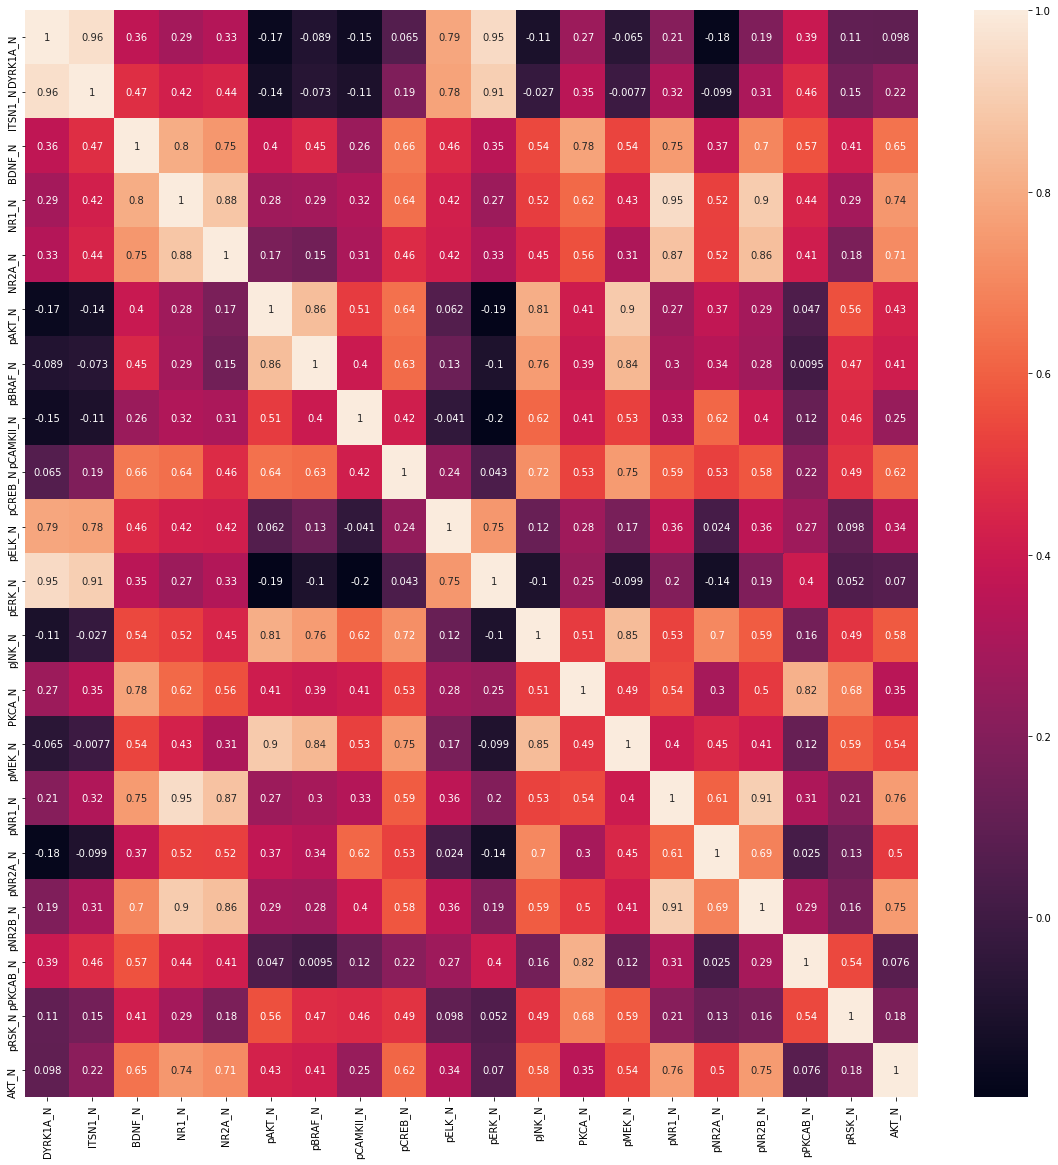

In [ ]:
plt.figure(figsize = (20,20))
corr = df[df.columns[[i for i in range(20)]]].corr()
sns.heatmap(corr, annot = True)

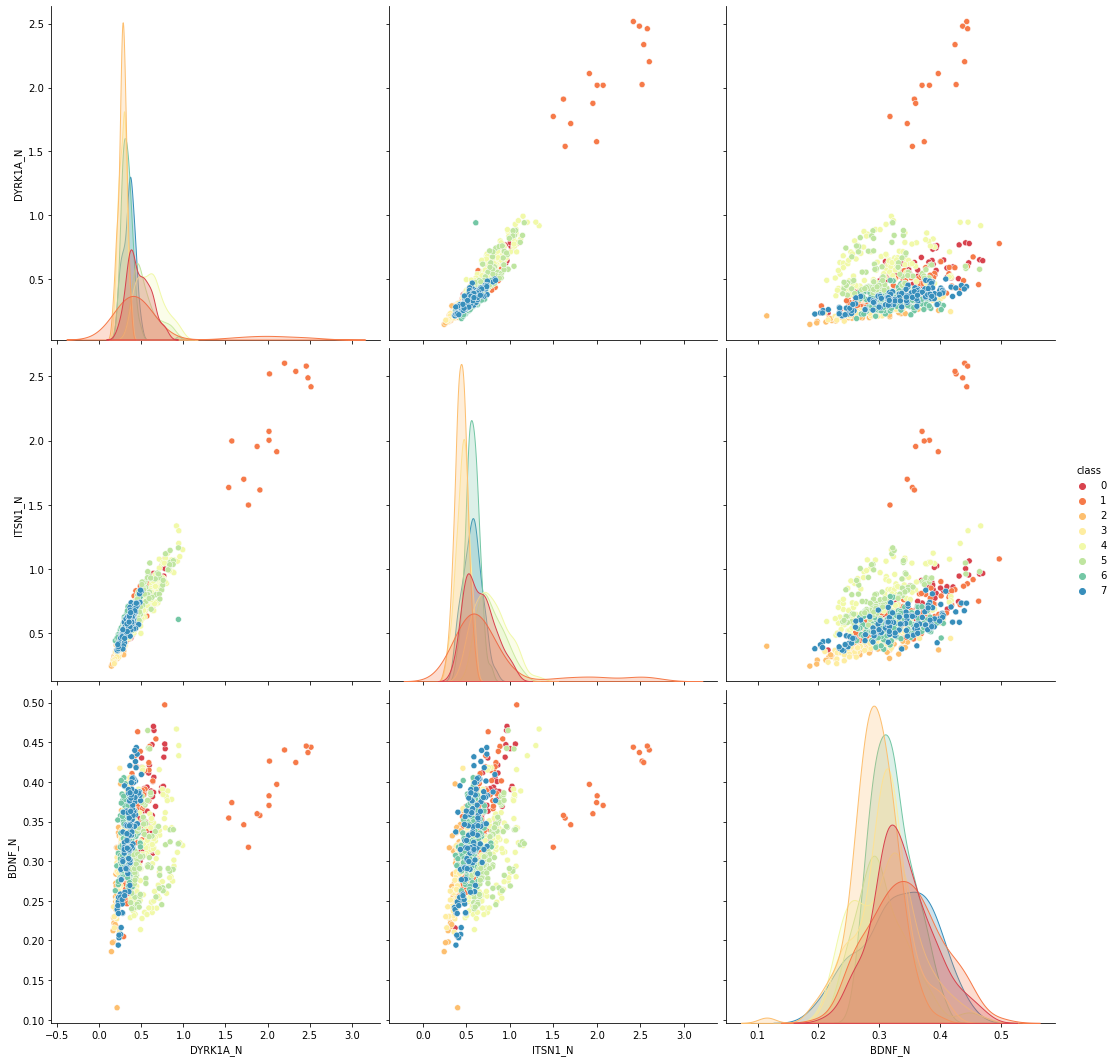

In [ ]:
sns.pairplot(t, hue='class', palette=sns.color_palette("Spectral", n_colors=8),height=5)

In [71]:
def draw_box_plot_per_class(col_i):
  clear_output()
  sns.catplot(x="class", y=df.columns[col_i], kind="box", data=df)

In [ ]:
ipywidgets.interact(draw_box_plot_per_class, col_i = [i for i in range(72)])

interactive(children=(Dropdown(description='col_i', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

<function __main__.draw_box_plot_per_class>

In [72]:
df.select_dtypes(exclude=['int', 'float']).columns

Index(['Genotype', 'Treatment', 'Behavior', 'class'], dtype='object')

В нашем датасете есть 4 колонки с категориальными данными: 'Genotype', 'Treatment', 'Behavior', 'class'
Метки класса просто занумеруем с помощью LabelEncoder. 
Остальные три признака удалим, так как они по сути составляют комбинации, представляющиее классы

In [212]:
df.drop(columns=['Genotype', 'Treatment', 'Behavior'],inplace=True)

In [213]:
from sklearn.preprocessing import LabelEncoder
#df = pd.get_dummies(df, columns=['Genotype', 'Treatment', 'Behavior'])
enc = LabelEncoder()
df['class'] = enc.fit_transform(df['class'])

In [76]:
df["class"].value_counts()

2    150
6    135
4    120
3    120
1    120
0    120
7    117
5     90
Name: class, dtype: int64

Количество элементов выборки по классам не совсем сбалансированно.

In [214]:
feature_names = list(df.columns)
feature_names.remove('class')
X = df[feature_names]
y = df['class']
# Split the data into 70% training data and 30% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# Train the scaler, which standarizes all the features to have mean=0 and unit variance
sc = StandardScaler()
sc.fit(X_train)
# Apply the scaler to the X training data
X_train_std = sc.transform(X_train)

# Apply the SAME scaler to the X test data
X_test_std = sc.transform(X_test)

Датасет 1. Перцептрон:

In [215]:
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform( np.array(y_train).reshape(-1, 1))

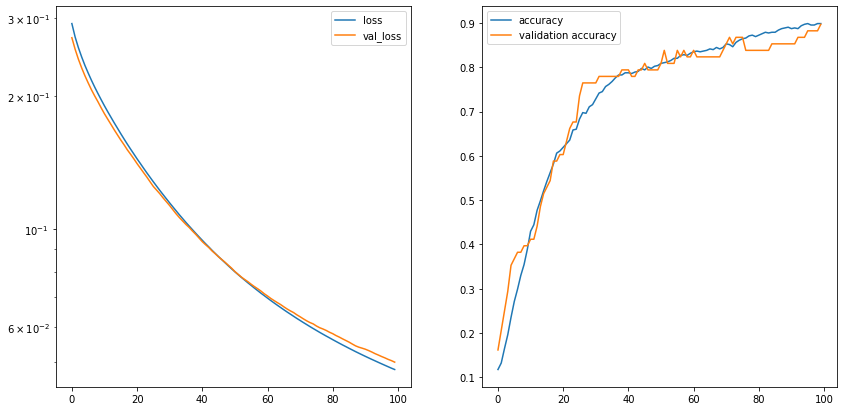

20/20 [==============================] - 1s 26ms/step - loss: 0.0481 - accuracy: 0.8987 - val_loss: 0.0499 - val_accuracy: 0.8971


In [224]:
model = Sequential()
model.add(Dense(8, input_shape=(X_train_std.shape[1],)))
model.add(Activation(hard_sigmoid))
sgd = SGD(learning_rate=0.1)
model.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])
model.fit(X_train_std,y,epochs=100, validation_split=0.1, callbacks=[plot_losses])

In [225]:
y_pred = model.predict_classes(X_test_std)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.70      0.80        47
           1       0.68      0.79      0.73        38
           2       0.90      0.79      0.84        47
           3       0.97      1.00      0.99        33
           4       0.62      0.77      0.69        31
           5       0.92      0.81      0.86        27
           6       0.83      0.92      0.88        38
           7       0.94      0.97      0.95        31

    accuracy                           0.84       292
   macro avg       0.85      0.84      0.84       292
weighted avg       0.85      0.84      0.84       292



Датасет 1. Линейный классификатор (логистическая регресия):

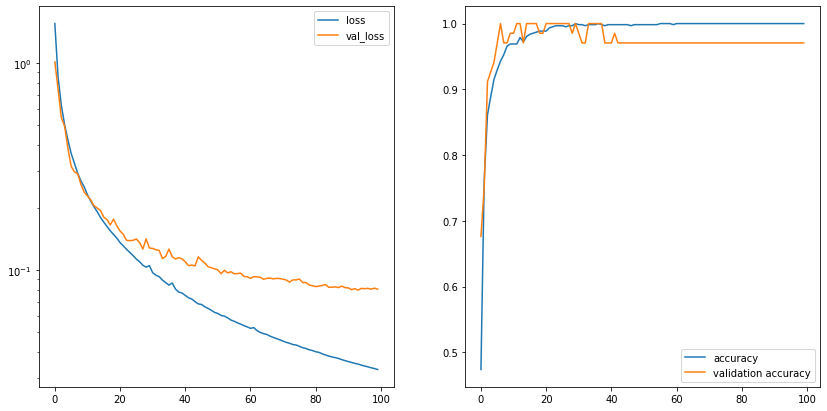

20/20 [==============================] - 0s 24ms/step - loss: 0.0331 - accuracy: 1.0000 - val_loss: 0.0808 - val_accuracy: 0.9706


In [226]:
model = Sequential()
model.add(Dense(8, input_shape=(X_train_std.shape[1],)))
model.add(Activation('softmax'))
sgd = SGD(learning_rate=0.1)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.fit(X_train_std,y,epochs=100, validation_split=0.1, callbacks=[plot_losses])

In [227]:
y_pred = model.predict_classes(X_test_std)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        47
           1       1.00      1.00      1.00        38
           2       1.00      0.96      0.98        47
           3       1.00      1.00      1.00        33
           4       1.00      1.00      1.00        31
           5       1.00      1.00      1.00        27
           6       1.00      1.00      1.00        38
           7       0.97      1.00      0.98        31

    accuracy                           0.99       292
   macro avg       0.99      0.99      0.99       292
weighted avg       0.99      0.99      0.99       292



Переходим к датасету № 2

In [291]:
df2 = pd.read_csv('abalone.csv') 
df2.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [229]:
pd.Series(df2.isna().sum())

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

В датасете Abalone нет пропущенных значенний

Классы очень несбалансированны

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



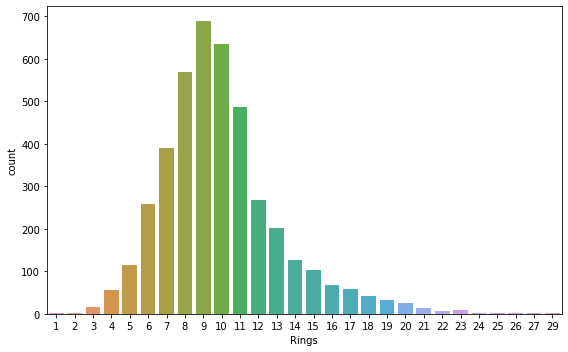

In [235]:
plt.figure(figsize=(8, 5))
sns.countplot(df2.Rings)
plt.tight_layout()

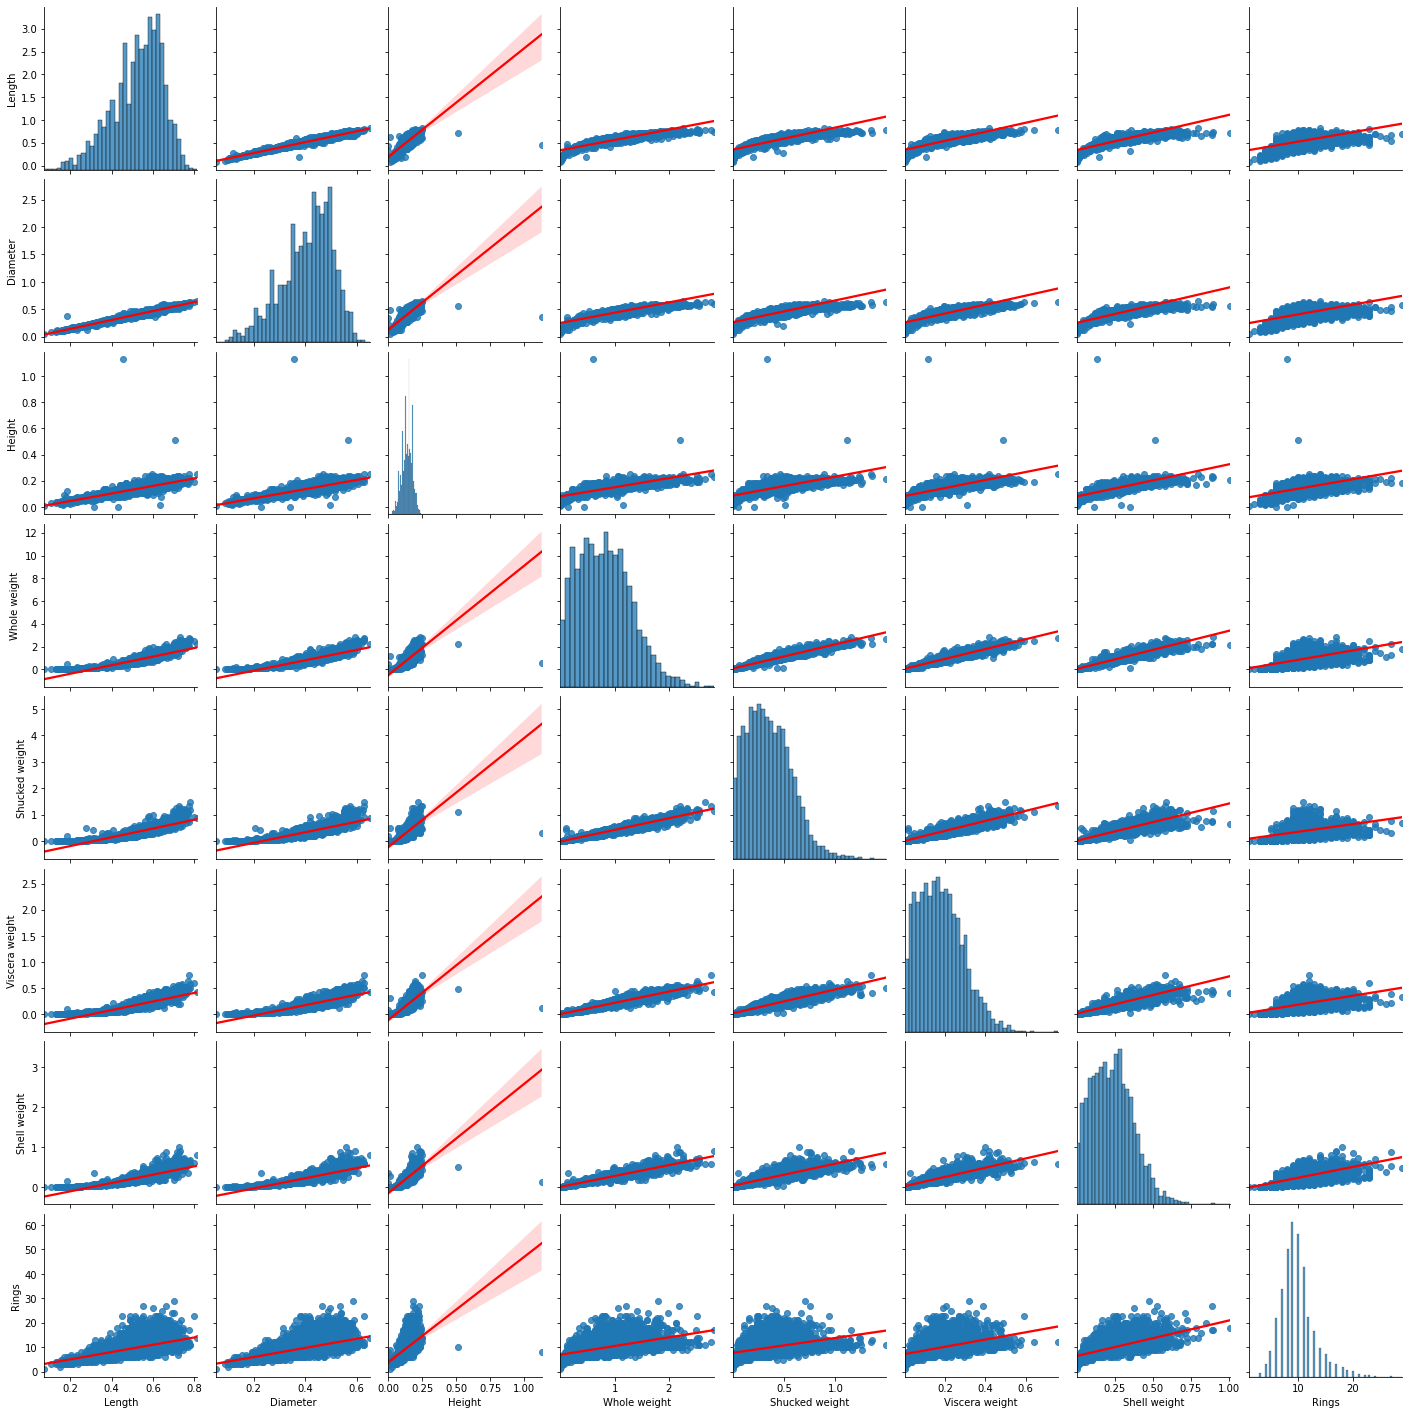

In [ ]:
sns.pairplot(df2.drop(['Sex'], axis=1),kind='reg',plot_kws={'line_kws':{'color':'red'}})

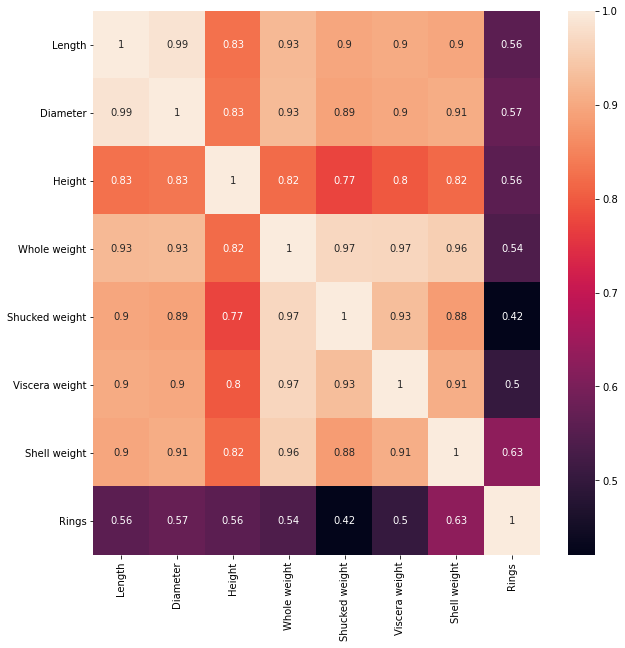

In [ ]:
plt.figure(figsize = (10,10))
corr = df2.corr()
sns.heatmap(corr, annot = True)

В датасете есть категориальный признак Sex (male, female, infant). Переведем его в числовое пространоство закодировав через onehotencoding

In [292]:
df2 = pd.get_dummies(df2, columns=['Sex'])
#enc = LabelEncoder()
#df2['Rings'] = enc.fit_transform(df2['Rings'])

In [293]:
feature_names = list(df2.columns)
feature_names.remove('Rings')
X = df2[feature_names]
y = df2['Rings']
# Split the data into 70% training data and 30% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# Train the scaler, which standarizes all the features to have mean=0 and unit variance
sc = StandardScaler()
sc.fit(X_train)
# Apply the scaler to the X training data
X_train_std = sc.transform(X_train)

# Apply the SAME scaler to the X test data
X_test_std = sc.transform(X_test)

Датасет 2: Однослойный перцептрон:

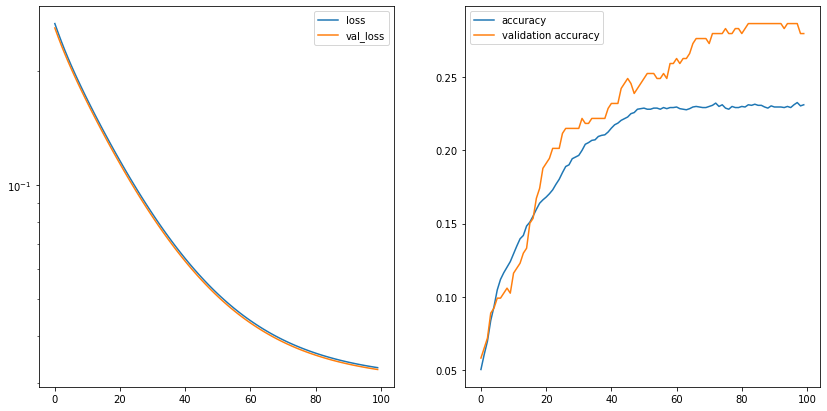

83/83 [==============================] - 1s 6ms/step - loss: 0.0330 - accuracy: 0.2312 - val_loss: 0.0326 - val_accuracy: 0.2799


In [245]:
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform( np.array(y_train).reshape(-1, 1))
model = Sequential()
model.add(Dense(28, input_shape=(X_train_std.shape[1],)))
model.add(Activation(hard_sigmoid))
sgd = SGD(learning_rate=0.1)
model.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])
model.fit(X_train_std,y,epochs=100, validation_split=0.1, callbacks=[plot_losses])

Accuracy очень мал. Это никак не может удовлетворять нас. Однако можно предположить, что в причина в классах. Если посмотреть на распредление по классам на графике выше, то можно увидеть, что тут было бы уместнее провести регрессию, а не классификацию. Но попытаемся улучшить результат и в рамках задания лабораторной: проранжируем зависимую переменную по группам : возраст 0-5, 6-10, 11-15, 16-20, 20-27. Таким образом у нас будет всего 5 классов, и хотя бы немного сгладим эффект несбалансированности классов.

Датасет 2: Однослойный перцептрон:

In [294]:
df_1 = df2.copy()
Age = []
for i in df_1["Rings"]:
    if i <= 5:
        Age.append("1")
    if i >= 6 and i <= 10 :
        Age.append("2")
    if i >= 11 and i <= 15 :
        Age.append("3")
    if i >= 16 and i <= 20 :
        Age.append("4")
    if i > 20:
        Age.append("5")
df_1["Age"] = Age
df_1.drop("Rings" , axis =1,inplace=True)
df_1.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_F,Sex_I,Sex_M,Age
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0,0,1,3
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0,0,1,2
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1,0,0,2
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0,0,1,2
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0,1,0,2


In [301]:
feature_names = list(df_1.columns)
feature_names.remove('Age')

X = df_1[feature_names]

df_1['Age'].astype(int)
y = df_1['Age'].astype(int)
# Split the data into 70% training data and 30% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# Train the scaler, which standarizes all the features to have mean=0 and unit variance
sc = StandardScaler()
sc.fit(X_train)
# Apply the scaler to the X training data
X_train_std = sc.transform(X_train)

# Apply the SAME scaler to the X test data
X_test_std = sc.transform(X_test)

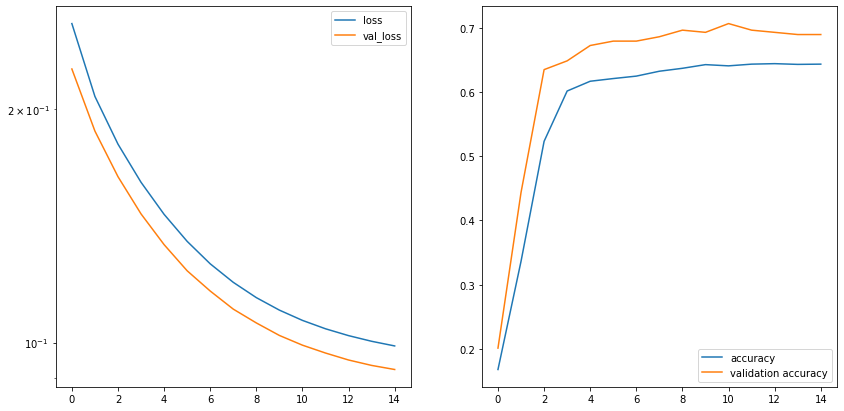

83/83 [==============================] - 1s 6ms/step - loss: 0.0990 - accuracy: 0.6433 - val_loss: 0.0923 - val_accuracy: 0.6894


In [302]:
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform( np.array(y_train).reshape(-1, 1))
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform( np.array(y_train).reshape(-1, 1))
model = Sequential()
model.add(Dense(5, input_shape=(X_train_std.shape[1],)))
model.add(Activation(hard_sigmoid))
sgd = SGD(learning_rate=0.1)
model.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])
model.fit(X_train_std,y,epochs=15, validation_split=0.1, callbacks=[plot_losses])

In [319]:
y_pred[0:1000]

array([1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1,
       2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,

In [320]:
y_pred = np.argmax(model.predict(X_train_std), axis=-1)
print(classification_report(y_train, y_pred,zero_division=1))

              precision    recall  f1-score   support

           1       0.06      1.00      0.10       137
           2       0.30      0.07      0.12      1796
           3       0.00      0.00      0.00       813
           4       1.00      0.00      0.00       154
           5       1.00      0.00      0.00        23

    accuracy                           0.09      2923
   macro avg       0.47      0.21      0.04      2923
weighted avg       0.25      0.09      0.08      2923



In [307]:
accuracy_score(y_test, y_pred)

0.08054226475279107

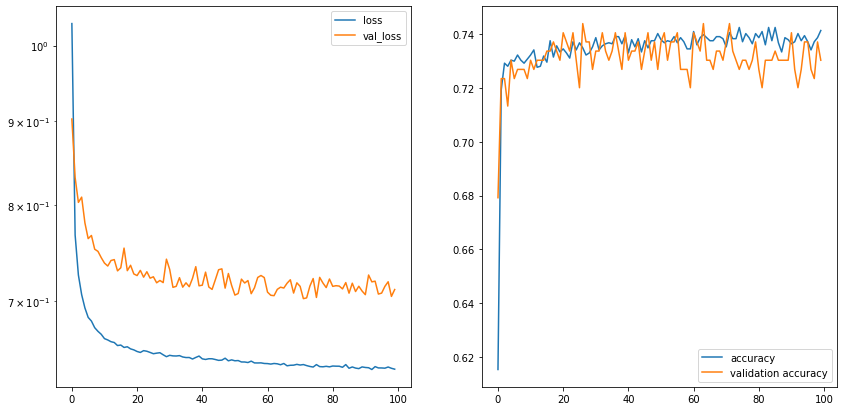

83/83 [==============================] - 1s 7ms/step - loss: 0.6363 - accuracy: 0.7414 - val_loss: 0.7112 - val_accuracy: 0.7304


In [290]:
model = Sequential()
model.add(Dense(5, input_shape=(X_train_std.shape[1],)))
model.add(Activation('softmax'))
sgd = SGD(learning_rate=0.1)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.fit(X_train_std,y,epochs=100, validation_split=0.1, callbacks=[plot_losses])

In [286]:
y_pred = model.predict_classes(X_train_std)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.05      0.37      0.08       301
           2       0.25      0.04      0.06      1962
           3       0.38      0.02      0.03       529
           4       0.00      0.00      0.00       114
           5       0.00      0.00      0.00        17

    accuracy                           0.06      2923
   macro avg       0.11      0.07      0.03      2923
weighted avg       0.24      0.06      0.06      2923



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [287]:
y_pred

array([2, 2, 2, ..., 1, 1, 1])

In [289]:
y_train.values

array([4, 5, 2, ..., 3, 2, 2])